In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import subprocess
import sys
import io
import gradio as gr
import numpy as np
import random
import spaces
import torch
from diffusers import Flux2Pipeline, Flux2Transformer2DModel, FluxInpaintPipeline
from diffusers import BitsAndBytesConfig as DiffBitsAndBytesConfig
import requests
from PIL import Image
import json
import base64
from dotenv import load_dotenv
from huggingface_hub import login, InferenceClient
from helper_dev_utils import get_auto_logger
import sys
from pathlib import Path
import helper_plot_hangul
import importlib
import gc
import logging
import copy
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from matplotlib.patches import Rectangle
from typing import List, Optional, Tuple, Dict, Any
from helper_plot_hangul import matplotlib_font_reset, matplotlib_font_get
from helper_dev_utils import *
from diffusers.utils import load_image
logger = get_auto_logger()

In [3]:
# Hugging Face 로그인 (FLUX 모델 접근 권한 필요)
load_dotenv()

# 환경 변수에서 토큰 가져오기 또는 직접 입력
hf_token = os.getenv("HF_TOKEN")
logger.info(f"Hugging Face Token: {hf_token[:2]} ... {hf_token[-2:]}")

if hf_token:
    login(token=hf_token)
    print("✓ Logged in with HF_TOKEN from environment")
else:
    # 수동 로그인 (토큰 입력 필요)
    login()
    print("✓ Manual login completed")

2026-01-16 23:11:49 I [ipykernel_launcher:6] - Hugging Face Token: hf ... LA


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


✓ Logged in with HF_TOKEN from environment


In [4]:
import sys
from pathlib import Path

# 프로젝트 경로 설정
project_root = Path.cwd().parent.parent / "src" / "nanoCocoa_aiserver"
sys.path.insert(0, str(project_root))
logger.debug(project_root)

import torch
import gc
from PIL import Image
from typing import Optional

from diffusers import DiffusionPipeline
from config import TORCH_DTYPE
from services.monitor import flush_gpu


2026-01-16 23:11:50 D [ipykernel_launcher:7] - /home/spai0433/codeit-ai-3team-ad-content/src/nanoCocoa_aiserver


In [5]:
import os
import logging
import torch
import logging

# ==========================================
# 설정 & 상수 (Configuration)
# ==========================================
DEVICE = "cuda"
TORCH_DTYPE = torch.bfloat16

# 모델 ID 정의
MODEL_IDS = {
    "SEG": "ZhengPeng7/BiRefNet",
    "FLUX": "black-forest-labs/FLUX.1-dev",
    "FLUX_4BIT": "diffusers/FLUX.1-dev-bnb-4bit",
    "FLUX_8BIT": "diffusers/FLUX.1-dev-bnb-8bit",
    "SDXL_BASE": "stabilityai/stable-diffusion-xl-base-1.0",
    "SDXL_CNET": "diffusers/controlnet-canny-sdxl-1.0",
    "SDXL_VAE": "madebyollin/sdxl-vae-fp16-fix"
}

# 예상 소요 시간 (초 단위, 초기값)
ESTIMATED_TIMES = {
    "init": 30,
    "stage_a": 300,  # 배경 생성 및 합성
    "stage_b": 200,  # 텍스트 자산 생성
    "stage_c": 90,   # 최종 합성 (Flux Inpainting 추가: 28 steps ≈ 30초)
}
TOTAL_ESTIMATED_TIME = sum(ESTIMATED_TIMES.values())


In [6]:
import torch
import warnings
from PIL import Image
from torchvision import transforms
from transformers import AutoModelForImageSegmentation
from config import DEVICE
from utils import flush_gpu

# timm 라이브러리 deprecation 경고 억제
warnings.filterwarnings("ignore", category=FutureWarning, module="timm")

class SegmentationModel:
    """
    BiRefNet을 사용하여 이미지 세그멘테이션(배경 제거)을 수행하는 클래스입니다.
    """
    def __init__(self):
        self.device = DEVICE

    def run(self, image: Image.Image) -> tuple[Image.Image, Image.Image]:
        """
        이미지의 배경을 제거합니다.
        
        Args:
            image (Image.Image): 입력 이미지
            
        Returns:
            tuple[Image.Image, Image.Image]: (배경 제거된 이미지, 마스크)
        """
        logger.debug("[Engine] Loading BiRefNet... (BiRefNet 모델 로딩 중)")
        flush_gpu()
        
        model = AutoModelForImageSegmentation.from_pretrained(
            MODEL_IDS["SEG"], trust_remote_code=True
        ).to(self.device).eval()

        W, H = image.size
        # 고해상도 처리를 위해 리사이즈 (필요 시 조정 가능)
        img_resized = image.resize((1024, 1024), Image.LANCZOS)
        
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        input_tensor = transform(img_resized).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            preds = model(input_tensor)[-1].sigmoid().cpu()
        
        pred = preds[0].squeeze()
        mask = transforms.ToPILImage()(pred).resize((W, H), Image.LANCZOS)
        
        # 마스크 이진화 (Thresholding)
        mask = mask.point(lambda x: 255 if x > 128 else 0)
        
        # 마스크 블러 처리 (외곽선 부드럽게)
        from PIL import ImageFilter
        mask = mask.filter(ImageFilter.GaussianBlur(radius=5))
        
        result = image.copy()
        result.putalpha(mask)
        
        # 리소스 정리
        del model, input_tensor
        flush_gpu()
        
        return result, mask

segmenter = SegmentationModel()
logger.debug("로딩 성공")

2026-01-16 23:11:50 D [ipykernel_launcher:70] - 로딩 성공


2026-01-16 23:11:51 D [ipykernel_launcher:29] - [Engine] Loading BiRefNet... (BiRefNet 모델 로딩 중)


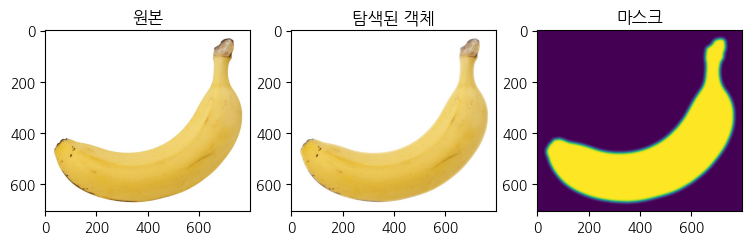

In [7]:
image_png = load_image("image.png").convert("RGB")

if "segmenter" in globals():
    del segmenter
    segmenter = None
    segmenter = SegmentationModel()
flush_gpu()

sm_result, sm_mask = segmenter.run(image_png)
# 저장
sm_result.save(r"outputs/image01_result.png")
sm_mask.save(r"outputs/image01_mask.png")

plt.figure(figsize=(9, 3))
ax1 = plt.subplot(1, 3, 1)
ax1.imshow(image_png)
ax1.set_title("원본")

ax1 = plt.subplot(1, 3, 2)
ax1.imshow(sm_result)
ax1.set_title("탐색된 객체")

ax2 = plt.subplot(1, 3, 3)
ax2.imshow(sm_mask)
ax2.set_title("마스크")
plt.show()


In [8]:
if "segmenter" in globals():
    del segmenter
    segmenter = None

# 강력한 GPU 메모리 정리
import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()
if hasattr(torch.cuda, 'ipc_collect'):
    torch.cuda.ipc_collect()

flush_gpu()
logger.debug("GPU Free")

2026-01-16 23:12:00 D [ipykernel_launcher:14] - GPU Free


In [9]:

class FluxGenerator:
    """
    - L4 GPU (22GB)에서 약 12~14GB VRAM 점유
    - txt2img, img2img, inpainting 파이프라인 지원
    """

    def __init__(self):
        self.model_id = MODEL_IDS["FLUX_4BIT"]
        
        self.pipe_txt2img = None
        self.pipe_img2img = None
        self.pipe_inpaint = None
        self.current_pipeline = None  # 현재 로드된 파이프라인 추적
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        logger.info(f"FluxGenerator initialized using: {self.model_id}")

    def _flush_gpu(self):
        flush_gpu()
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    def _unload_pipeline(self, pipeline_name: str):
        """특정 파이프라인을 메모리에서 언로드"""
        if pipeline_name == "txt2img" and self.pipe_txt2img is not None:
            logger.info("Unloading txt2img pipeline")
            del self.pipe_txt2img
            self.pipe_txt2img = None
        elif pipeline_name == "img2img" and self.pipe_img2img is not None:
            logger.info("Unloading img2img pipeline")
            del self.pipe_img2img
            self.pipe_img2img = None
        elif pipeline_name == "inpaint" and self.pipe_inpaint is not None:
            logger.info("Unloading inpaint pipeline")
            del self.pipe_inpaint
            self.pipe_inpaint = None
        self._flush_gpu()
    
    def unload_all_pipelines(self):
        """모든 파이프라인을 메모리에서 언로드 (외부 모델 로드 전 호출)"""
        logger.info("Unloading all pipelines to free GPU memory")
        if self.pipe_txt2img is not None:
            del self.pipe_txt2img
            self.pipe_txt2img = None
        if self.pipe_img2img is not None:
            del self.pipe_img2img
            self.pipe_img2img = None
        if self.pipe_inpaint is not None:
            del self.pipe_inpaint
            self.pipe_inpaint = None
        self.current_pipeline = None
        self._flush_gpu()
        logger.info("All pipelines unloaded")

    def _load_txt2img_pipeline(self):
        if self.pipe_txt2img is not None:
            return self.pipe_txt2img

        # 다른 파이프라인이 로드되어 있으면 언로드
        if self.current_pipeline not in [None, "txt2img"]:
            logger.info(f"Switching from {self.current_pipeline} to txt2img")
            self._unload_pipeline(self.current_pipeline)

        logger.info(f"Loading Quantized Pipeline from {self.model_id}...")
        self._flush_gpu()
        
        # 파이프라인 로드
        self.pipe_txt2img = DiffusionPipeline.from_pretrained(
            self.model_id,
            torch_dtype=TORCH_DTYPE,
        )
        
        # CPU 오프로드로 메모리 절약
        self.pipe_txt2img.enable_model_cpu_offload()
        
        self.current_pipeline = "txt2img"
        logger.info("Pipeline loaded with CPU offload (Memory Optimized Mode)")
        return self.pipe_txt2img

    def _load_img2img_pipeline(self):
        """img2img 파이프라인 로드"""
        if self.pipe_img2img is not None:
            return self.pipe_img2img

        # 다른 파이프라인이 로드되어 있으면 언로드
        if self.current_pipeline not in [None, "img2img"]:
            logger.info(f"Switching from {self.current_pipeline} to img2img")
            self._unload_pipeline(self.current_pipeline)

        logger.info(f"Loading Img2Img Pipeline from {self.model_id}...")
        self._flush_gpu()
        
        from diffusers import FluxImg2ImgPipeline
        
        self.pipe_img2img = FluxImg2ImgPipeline.from_pretrained(
            self.model_id,
            torch_dtype=TORCH_DTYPE,
        )
        
        # CPU 오프로드로 메모리 절약
        self.pipe_img2img.enable_model_cpu_offload()
        
        self.current_pipeline = "img2img"
        logger.info("Img2Img Pipeline loaded with CPU offload")
        return self.pipe_img2img

    def _load_inpaint_pipeline(self):
        """Inpainting 파이프라인 로드 - txt2img 파이프라인에서 변환"""
        if self.pipe_inpaint is not None:
            return self.pipe_inpaint

        logger.info("Loading Inpainting Pipeline...")
        
        # txt2img 파이프라인이 이미 로드되어 있으면 재사용
        if self.pipe_txt2img is not None:
            logger.info("Converting txt2img pipeline to inpaint pipeline (memory efficient)")
            self._flush_gpu()
            
            # txt2img 파이프라인의 컴포넌트를 재사용하여 inpaint 파이프라인 생성
            from diffusers import FluxInpaintPipeline
            
            self.pipe_inpaint = FluxInpaintPipeline(
                scheduler=self.pipe_txt2img.scheduler,
                text_encoder=self.pipe_txt2img.text_encoder,
                text_encoder_2=self.pipe_txt2img.text_encoder_2,
                tokenizer=self.pipe_txt2img.tokenizer,
                tokenizer_2=self.pipe_txt2img.tokenizer_2,
                transformer=self.pipe_txt2img.transformer,
                vae=self.pipe_txt2img.vae,
            )
            
            # txt2img 파이프라인 언로드
            del self.pipe_txt2img
            self.pipe_txt2img = None
            self._flush_gpu()
            
            # CPU 오프로드 활성화
            self.pipe_inpaint.enable_model_cpu_offload()
            
        else:
            # txt2img가 없으면 새로 로드
            if self.current_pipeline not in [None, "inpaint"]:
                logger.info(f"Switching from {self.current_pipeline} to inpaint")
                self._unload_pipeline(self.current_pipeline)
            
            self._flush_gpu()
            
            self.pipe_inpaint = FluxInpaintPipeline.from_pretrained(
                self.model_id,
                torch_dtype=TORCH_DTYPE,
            )
            
            # CPU 오프로드로 메모리 절약
            self.pipe_inpaint.enable_model_cpu_offload()
        
        self.current_pipeline = "inpaint"
        logger.info("Inpainting Pipeline loaded with CPU offload (Memory Optimized)")
        return self.pipe_inpaint

    def generate_background_txt2img(
        self,
        prompt: str,
        width: int = 1024,
        height: int = 1024,
        num_inference_steps: int = 25,
        guidance_scale: float = 3.5,
        seed: int = None,
        **kwargs
    ) -> Image.Image:
        """
        txt2img 생성 (기존 메서드)
        """
        # 시드 설정
        generator = None
        if seed is not None:
            generator = torch.Generator(device="cpu").manual_seed(seed)
        
        logger.info(f"Generating image... Prompt: {prompt[:50]}")
        
        # 파이프라인 로드
        pipe = self._load_txt2img_pipeline() 
        self._flush_gpu()

        # 추론 실행
        with torch.no_grad():
            result = pipe(
                prompt=prompt,
                width=width,
                height=height,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                generator=generator,
                max_sequence_length=512
            )
        
        image = result.images[0]
        self._flush_gpu()
        return image

    def _generate_img2img_fast_mode(
        self,
        prompt: str,
        product_foreground: Image.Image,
        product_mask: Image.Image,
        position: str = "center",
        scale: float = 0.4,
        width: int = 1024,
        height: int = 1024,
        num_inference_steps: int = 25,
        guidance_scale: float = 3.5,
        img2img_strength: float = 0.75,
        seed: int = None,
        return_intermediates: bool = False,
    ) -> Image.Image:
        """
        Fast Mode: img2img 단일 파이프라인으로 한 번에 처리
        
        장점: 빠른 처리 속도, 메모리 효율
        단점: 상품 보존 불확실, 경계 블렌딩 부족
        
        프로세스:
        1. 빈 배경에 상품 배치 (Alpha Composite)
        2. img2img로 배경 프롬프트 기반 재생성 (한 번에 처리)
        
        Args:
            prompt: 배경 생성 프롬프트
            product_foreground: 세그멘테이션된 상품 이미지 (RGBA)
            product_mask: 상품 마스크 (L 모드)
            position: 상품 배치 위치
            scale: 상품 크기 스케일
            width, height: 출력 해상도
            num_inference_steps: 샘플링 스텝 수
            guidance_scale: 가이던스 스케일
            img2img_strength: 재생성 강도 (높을수록 프롬프트 우선, 낮을수록 입력 이미지 보존)
            seed: 랜덤 시드
            return_intermediates: 중간 결과 반환 여부
            
        Returns:
            최종 이미지 또는 중간 결과 dict
        """
        logger.info(f"[FAST MODE] Generating with img2img: prompt='{prompt[:50]}...', strength={img2img_strength}")
        
        # RGBA 검증
        if product_foreground.mode != "RGBA":
            raise ValueError(f"product_foreground must be RGBA format, got {product_foreground.mode}")
        
        # 1. 빈 배경에 상품 배치
        logger.info("Step 1/2: Placing product on blank background")
        background = Image.new("RGB", (width, height), (240, 240, 240))  # 회색 배경
        
        # 상품 리사이즈
        fg_resized = product_foreground.resize(
            (int(product_foreground.width * scale), int(product_foreground.height * scale)),
            Image.LANCZOS
        )
        mask_resized = product_mask.convert("L").resize(fg_resized.size, Image.LANCZOS)
        
        # 배치 위치 계산
        if isinstance(position, str):
            if position == "center":
                x = (width - fg_resized.width) // 2
                y = (height - fg_resized.height) // 2
            elif position == "bottom":
                x = (width - fg_resized.width) // 2
                y = int(height * 0.6)
            else:
                raise ValueError(f"Invalid position: {position}")
        else:
            x, y = position
        
        # Alpha Composite
        draft = background.convert("RGBA")
        draft.paste(fg_resized, (x, y), fg_resized)
        draft_rgb = draft.convert("RGB")
        
        logger.info(f"Product placed at ({x}, {y}), size={fg_resized.size}")
        
        # 2. img2img로 한 번에 처리
        logger.info("Step 2/2: Running img2img to generate background")
        pipe = self._load_img2img_pipeline()
        self._flush_gpu()
        
        # Generator 설정
        generator = None
        if seed is not None:
            generator = torch.Generator(device="cpu").manual_seed(seed)
        
        # img2img 실행
        with torch.no_grad():
            result = pipe(
                prompt=prompt,
                image=draft_rgb,
                strength=img2img_strength,  # 높을수록 재생성 강도 증가
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                generator=generator,
            ).images[0]
        
        self._flush_gpu()
        logger.info("[FAST MODE] Composition completed")
        
        # 중간 결과 반환
        if return_intermediates:
            return {
                'final': result,
                'background': background,
                'fg_resized': fg_resized,
                'mask_original': mask_resized,
                'mask_processed': None,  # Fast mode는 마스크 전처리 없음
                'draft': draft_rgb,
                'full_mask': None,  # Inpainting 없음
                'mode': 'fast'
            }
        return result

    def generate_img2img_from_segmented(
        self,
        prompt: str,
        product_foreground: Image.Image,
        product_mask: Image.Image,
        position: str = "center",
        scale: float = 0.4,
        width: int = 1024,
        height: int = 1024,
        num_inference_steps: int = 25,
        guidance_scale: float = 3.5,
        inpaint_strength: float = 0.25,
        img2img_strength: float = 0.75,
        use_inpainting: bool = True,
        use_fast_mode: bool = False,
        seed: int = None,
        return_intermediates: bool = False,
        **kwargs
    ) -> Image.Image:
        """
        사전 세그멘테이션된 상품 이미지로 배경 합성
        
        프로세스:
        - use_fast_mode=False (기본값): txt2img → composite → inpaint (고품질, 느림)
        - use_fast_mode=True: img2img 단일 처리 (빠름, 상품 변형 위험)
        
        Args:
            prompt: 배경 생성 프롬프트
            product_foreground: 세그멘테이션된 상품 이미지 (RGBA, 알파 채널 포함)
            product_mask: 상품 마스크 (L 모드)
            position: 상품 배치 위치 ("center" | "bottom" | (x, y) 튜플)
            scale: 상품 크기 스케일 (0.3~0.6 권장, 기본값 0.4)
            width, height: 출력 해상도
            num_inference_steps: 배경 생성 샘플링 스텝 수
            guidance_scale: 가이던스 스케일
            inpaint_strength: Inpainting 강도 (0.25 권장, 외곽선만 블렌딩) - Standard Mode
            img2img_strength: img2img 재생성 강도 (0.75 권장) - Fast Mode
            use_inpainting: Inpainting 사용 여부 (True: 자연스러움, False: 빠름) - Standard Mode
            use_fast_mode: Fast Mode 사용 여부 (False: 고품질, True: 빠른 처리)
            seed: 랜덤 시드 (재현성)
            return_intermediates: True면 중간 결과도 함께 반환 (디버깅용)
            
        Returns:
            return_intermediates=False: 최종 이미지 (PIL.Image)
            return_intermediates=True: dict {
                'final': 최종 이미지,
                'background': 생성된 배경,
                'fg_resized': 리사이즈된 상품,
                'mask_original': 원본 마스크 (리사이즈),
                'mask_processed': 전처리된 마스크 (Dilation + Blur),
                'draft': Alpha Composite 결과,
                'full_mask': Inpainting에 사용된 전체 마스크,
                'mode': 'fast' | 'standard'
            }
        """
        # Fast Mode 분기
        if use_fast_mode:
            logger.info("Using FAST MODE (img2img single pipeline)")
            return self._generate_img2img_fast_mode(
                prompt=prompt,
                product_foreground=product_foreground,
                product_mask=product_mask,
                position=position,
                scale=scale,
                width=width,
                height=height,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                img2img_strength=img2img_strength,
                seed=seed,
                return_intermediates=return_intermediates,
            )
        
        # Standard Mode (기존 로직)
        logger.info(f"Using STANDARD MODE (txt2img → composite → inpaint): prompt='{prompt[:50]}...', scale={scale}, use_inpainting={use_inpainting}")
        
        # RGBA 검증
        if product_foreground.mode != "RGBA":
            raise ValueError(f"product_foreground must be RGBA format, got {product_foreground.mode}")
        
        # 1. 배경 생성 (txt2img)
        logger.info("Step 1/3: Generating background from prompt")
        background = self.generate_background_txt2img(
            prompt=prompt,
            width=width,
            height=height,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            seed=seed
        )
        logger.info(f"Background generated: size={background.size}")
        
        # 2. 상품 리사이즈 및 배치 계산
        logger.info("Step 2/3: Compositing product onto background")
        bg_w, bg_h = background.size
        
        # 상품 리사이즈 (scale 적용)
        fg_resized = product_foreground.resize(
            (int(product_foreground.width * scale), int(product_foreground.height * scale)),
            Image.LANCZOS
        )
        mask_resized = product_mask.convert("L").resize(fg_resized.size, Image.LANCZOS)
        mask_original = mask_resized.copy()  # 원본 마스크 보존 (디버깅용)
        
        # 마스크 전처리: 경계 확장 + 약한 블러 (외곽선만 자연스럽게)
        from PIL import ImageFilter, ImageOps
        mask_resized = mask_resized.filter(ImageFilter.MaxFilter(size=3))  # Dilation (약하게)
        mask_resized = mask_resized.filter(ImageFilter.GaussianBlur(radius=5))  # Blur (약하게)
        mask_processed = mask_resized.copy()  # 전처리된 마스크 보존 (디버깅용)
        
        # 배치 위치 계산
        if isinstance(position, str):
            if position == "center":
                x = (bg_w - fg_resized.width) // 2
                y = (bg_h - fg_resized.height) // 2
            elif position == "bottom":
                x = (bg_w - fg_resized.width) // 2
                y = int(bg_h * 0.6)  # 하단 60% 위치
            else:
                raise ValueError(f"Invalid position: {position}. Use 'center', 'bottom', or (x, y) tuple")
        else:
            x, y = position
        
        logger.info(f"Product placement: position=({x}, {y}), size={fg_resized.size}")
        
        # 3. Alpha Composite (초안 합성)
        draft = background.copy().convert("RGBA")
        draft.paste(fg_resized, (x, y), fg_resized)
        draft_rgb = draft.convert("RGB")
        
        # 4. Inpainting으로 자연스럽게 통합 (선택적)
        full_mask = None
        if use_inpainting:
            logger.info(f"Step 3/3: Applying Inpainting for natural blending (strength={inpaint_strength})")
            
            # 전체 크기 마스크 생성 (반전: 배경만 Inpaint, 상품은 보존)
            full_mask = Image.new("L", (bg_w, bg_h), 255)  # 배경=255 (Inpaint 대상)
            # 상품 영역만 0으로 마스킹 (보존 영역)
            from PIL import ImageOps
            mask_inverted = ImageOps.invert(mask_resized)
            full_mask.paste(mask_inverted, (x, y))
            
            # Inpainting 파이프라인 로드
            pipe = self._load_inpaint_pipeline()
            self._flush_gpu()
            
            # Generator 설정
            generator = None
            if seed is not None:
                generator = torch.Generator(device="cpu").manual_seed(seed)
            
            # Inpainting 실행
            with torch.no_grad():
                result = pipe(
                    prompt=prompt,
                    image=draft_rgb,
                    mask_image=full_mask,
                    strength=inpaint_strength,
                    guidance_scale=guidance_scale,
                    num_inference_steps=28,  # Inpainting은 28 steps 권장
                    generator=generator,
                ).images[0]
            
            self._flush_gpu()
            logger.info("[STANDARD MODE] Inpainting composition completed successfully")
            
            # 중간 결과 반환 (디버깅용)
            if return_intermediates:
                return {
                    'final': result,
                    'background': background,
                    'fg_resized': fg_resized,
                    'mask_original': mask_original,
                    'mask_processed': mask_processed,
                    'draft': draft_rgb,
                    'full_mask': full_mask,
                    'mode': 'standard'
                }
            return result
        else:
            logger.info("Step 3/3: Skipping Inpainting (simple composite)")
            self._flush_gpu()
            logger.info("[STANDARD MODE] Simple composition completed successfully")
            
            # 중간 결과 반환 (디버깅용)
            if return_intermediates:
                return {
                    'final': draft_rgb,
                    'background': background,
                    'fg_resized': fg_resized,
                    'mask_original': mask_original,
                    'mask_processed': mask_processed,
                    'draft': draft_rgb,
                    'full_mask': None,
                    'mode': 'standard'
                }
            return draft_rgb

    def generate_img2img(
        self,
        prompt: str,
        input_image: Image.Image,
        position: str = "center",
        scale: float = 0.4,
        width: int = 1024,
        height: int = 1024,
        num_inference_steps: int = 25,
        guidance_scale: float = 3.5,
        inpaint_strength: float = 0.7,
        img2img_strength: float = 0.75,
        use_inpainting: bool = True,
        use_fast_mode: bool = False,
        seed: int = None,
        return_intermediates: bool = False,
        **kwargs
    ):
        """
        배경 생성 + 세그멘테이션 + 상품 합성 파이프라인
        
        프로세스:
        - RGB 입력: 세그멘테이션 수행 후 배경 합성 (메모리 집약적, OOM 위험)
        - RGBA 입력: 사전 세그멘테이션된 이미지로 간주하여 바로 배경 합성 (권장)
        
        Args:
            prompt: 배경 생성 프롬프트
            input_image: 상품 이미지 (RGB: 원본 / RGBA: 사전 세그멘테이션)
            position: 상품 배치 위치 ("center" | "bottom" | (x, y) 튜플)
            scale: 상품 크기 스케일 (0.3~0.6 권장, 기본값 0.4)
            width, height: 출력 해상도
            num_inference_steps: 배경 생성 샘플링 스텝 수
            guidance_scale: 가이던스 스케일
            inpaint_strength: Inpainting 강도 (0.7 권장) - Standard Mode
            img2img_strength: img2img 재생성 강도 (0.75 권장) - Fast Mode
            use_inpainting: Inpainting 사용 여부 - Standard Mode
            use_fast_mode: Fast Mode 사용 여부 (False: 고품질, True: 빠른 처리)
            seed: 랜덤 시드 (재현성)
            return_intermediates: True면 중간 결과도 함께 반환 (디버깅용)
            
        Returns:
            return_intermediates=False: 최종 이미지 (PIL.Image)
            return_intermediates=True: dict (중간 결과 포함)
        """
        # 타입 체크: RGBA면 사전 세그멘테이션으로 간주
        if input_image.mode == "RGBA":
            logger.info("Detected RGBA input - using pre-segmented workflow")
            # RGBA 입력의 경우 마스크 추출
            alpha_channel = input_image.split()[-1]
            return self.generate_img2img_from_segmented(
                prompt=prompt,
                product_foreground=input_image,
                product_mask=alpha_channel,
                position=position,
                scale=scale,
                width=width,
                height=height,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                inpaint_strength=inpaint_strength,
                img2img_strength=img2img_strength,
                use_inpainting=use_inpainting,
                use_fast_mode=use_fast_mode,
                seed=seed,
                return_intermediates=return_intermediates,
                **kwargs
            )
        
        # RGB 입력: 세그멘테이션 수행 (메모리 위험)
        logger.warning("RGB input detected - performing segmentation (OOM risk on low VRAM)")
        logger.info(f"Starting product composition pipeline: prompt='{prompt[:50]}...', scale={scale}")
        
        # 1. 세그멘테이션 (상품 분리)
        logger.info("Step 1/4: Segmentation - Extracting product from input image")
        segmenter = SegmentationModel()
        self._flush_gpu()
        
        product_fg, product_mask = segmenter.run(input_image)
        logger.info(f"Product extracted: size={product_fg.size}, mode={product_fg.mode}")
        
        # 세그멘테이션 모델 언로드
        del segmenter
        self._flush_gpu()
        
        # 2. 사전 세그멘테이션 워크플로우로 위임
        return self.generate_img2img_from_segmented(
            prompt=prompt,
            product_foreground=product_fg,
            product_mask=product_mask,
            position=position,
            scale=scale,
            width=width,
            height=height,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            inpaint_strength=inpaint_strength,
            img2img_strength=img2img_strength,
            use_inpainting=use_inpainting,
            use_fast_mode=use_fast_mode,
            seed=seed,
            return_intermediates=return_intermediates,
            **kwargs
        )


flux_generator = FluxGenerator()


2026-01-16 23:12:00 I [ipykernel_launcher:15] - FluxGenerator initialized using: diffusers/FLUX.1-dev-bnb-4bit


2026-01-16 23:12:01 I [ipykernel_launcher:12] - Step 0: Unload FluxGenerator to free memory for segmentation
2026-01-16 23:12:01 I [ipykernel_launcher:41] - Unloading all pipelines to free GPU memory
2026-01-16 23:12:02 I [ipykernel_launcher:53] - All pipelines unloaded
2026-01-16 23:12:02 I [ipykernel_launcher:16] - Step 1: Pre-segmentation
2026-01-16 23:12:02 D [ipykernel_launcher:29] - [Engine] Loading BiRefNet... (BiRefNet 모델 로딩 중)
2026-01-16 23:12:06 I [ipykernel_launcher:21] - Segmentation completed, GPU memory released
2026-01-16 23:12:06 I [ipykernel_launcher:24] - Step 2: Background generation and composition
2026-01-16 23:12:06 I [ipykernel_launcher:560] - Detected RGBA input - using pre-segmented workflow
2026-01-16 23:12:06 I [ipykernel_launcher:390] - Using STANDARD MODE (txt2img → composite → inpaint): prompt='
In the foreground, resting on a rustic, worn wood...', scale=0.7, use_inpainting=True
2026-01-16 23:12:06 I [ipykernel_launcher:397] - Step 1/3: Generating backgro

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

2026-01-16 23:13:18 I [ipykernel_launcher:77] - Pipeline loaded with CPU offload (Memory Optimized Mode)


Token indices sequence length is longer than the specified maximum sequence length for this model (148 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['beading on its surface. the background is a warmly lit, bustling retro korean pub ( pocha ) interior, featuring blurred hanging lanterns and string lights. the upper half of the frame is empty negative space with soft focus, designed for text placement. cinematic lighting, highly detailed texture, appetizing food photography style, 8 k resolution, no text.']


  0%|          | 0/20 [00:00<?, ?it/s]

2026-01-16 23:14:40 I [ipykernel_launcher:406] - Background generated: size=(1024, 1024)
2026-01-16 23:14:40 I [ipykernel_launcher:409] - Step 2/3: Compositing product onto background
2026-01-16 23:14:40 I [ipykernel_launcher:439] - Product placement: position=(232, 265), size=(560, 493)
2026-01-16 23:14:40 I [ipykernel_launcher:449] - Step 3/3: Applying Inpainting for natural blending (strength=0.5)
2026-01-16 23:14:40 I [ipykernel_launcher:112] - Loading Inpainting Pipeline...
2026-01-16 23:14:40 I [ipykernel_launcher:116] - Converting txt2img pipeline to inpaint pipeline (memory efficient)
2026-01-16 23:14:42 I [ipykernel_launcher:157] - Inpainting Pipeline loaded with CPU offload (Memory Optimized)


The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['beading on its surface. the background is a warmly lit, bustling retro korean pub ( pocha ) interior, featuring blurred hanging lanterns and string lights. the upper half of the frame is empty negative space with soft focus, designed for text placement. cinematic lighting, highly detailed texture, appetizing food photography style, 8 k resolution, no text.']


  0%|          | 0/14 [00:00<?, ?it/s]

2026-01-16 23:17:29 I [ipykernel_launcher:480] - [STANDARD MODE] Inpainting composition completed successfully


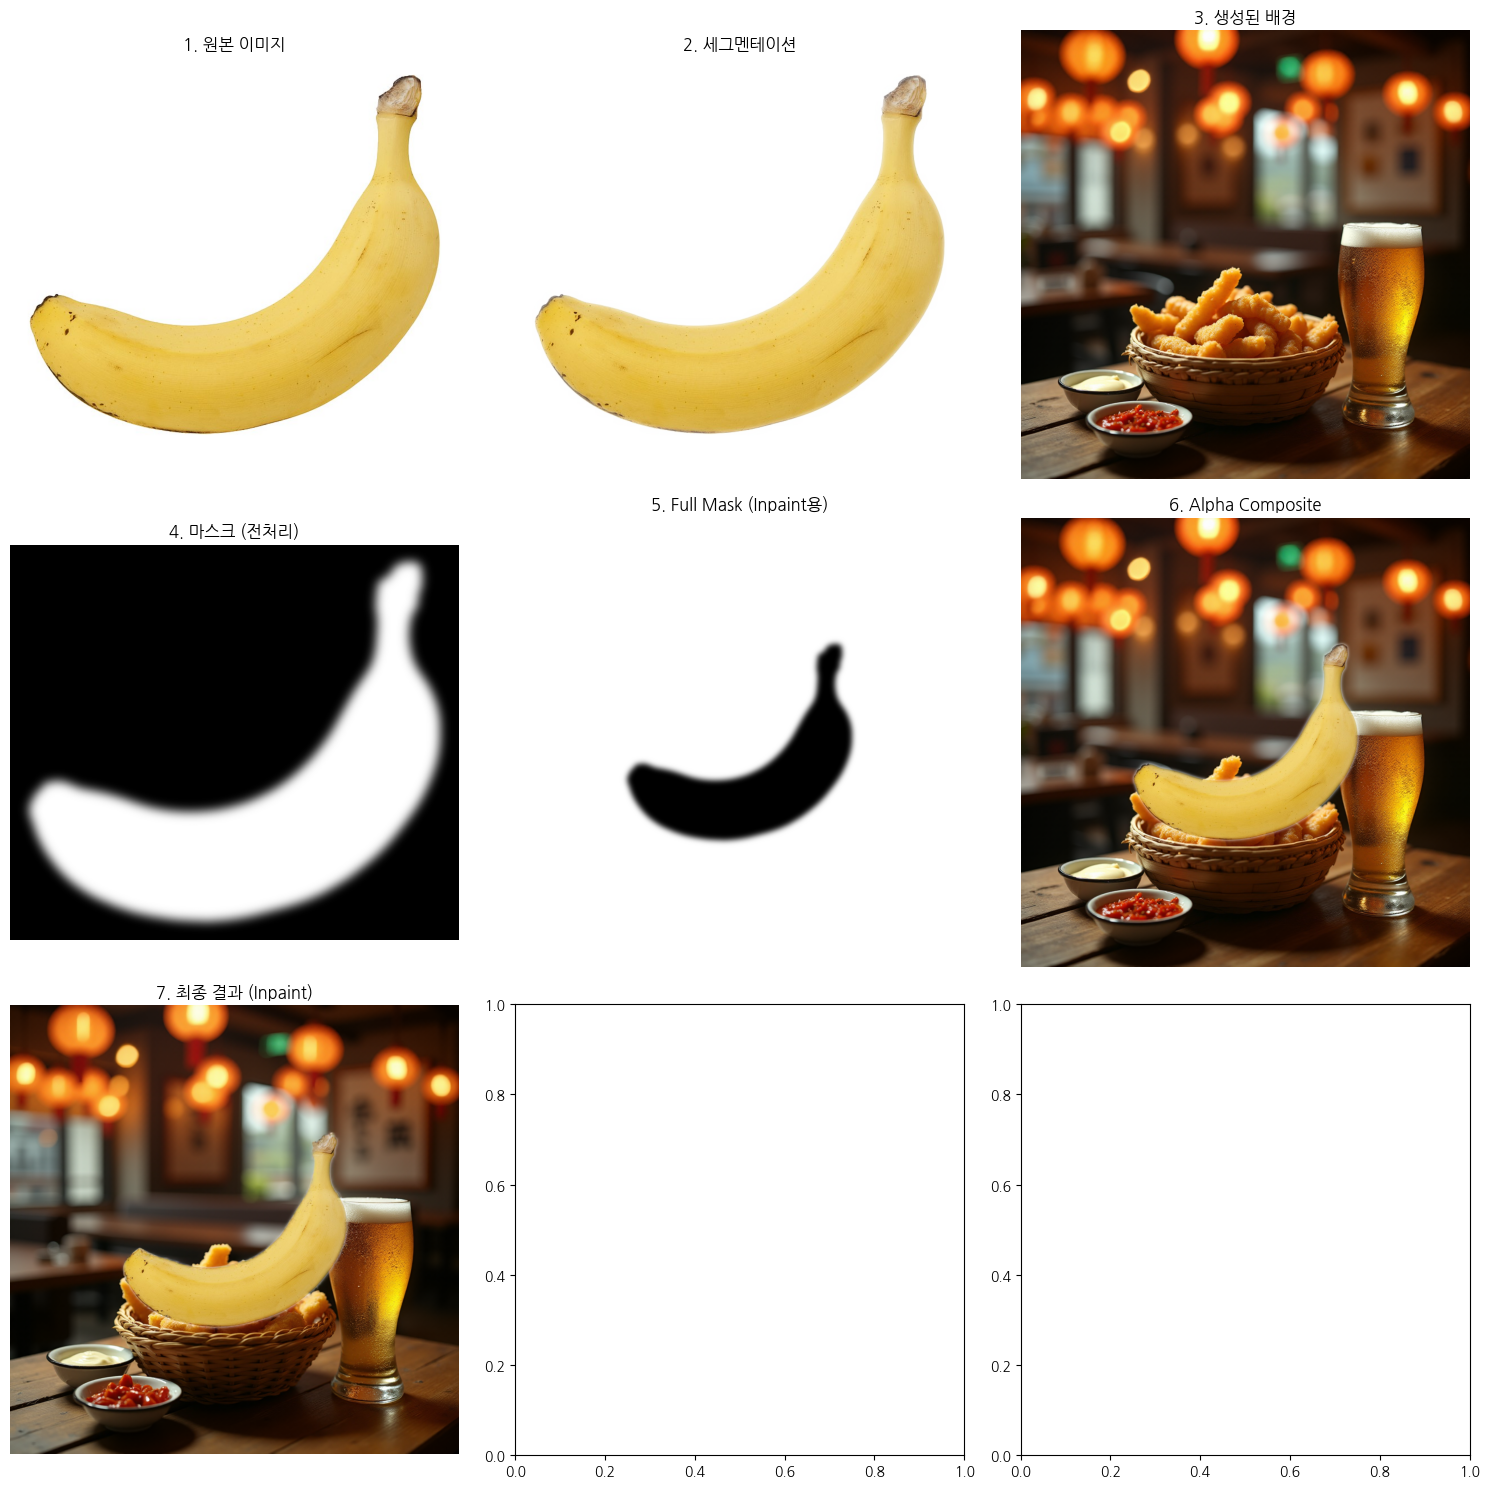

In [10]:
import matplotlib.pyplot as plt

# 테스트 1: 메모리 최적화 워크플로우 (사전 세그멘테이션 + 배경 합성)
# bg_prompt = """A rustic wooden table surface with soft natural lighting from the side, 
# bokeh background of a sunlit kitchen, warm color tones, realistic textures, 
# ultra-detailed 8K product photography background"""

bg_prompt = """
In the foreground, resting on a rustic, worn wooden table, is a bamboo basket holding the exact items as shown in the input image. They possess the identical marks and textures as the original. Next to the basket is a frosty glass of draft beer with condensation beading on its surface. The background is a warmly lit, bustling retro Korean pub (pocha) interior, featuring blurred hanging lanterns and string lights. The upper half of the frame is empty negative space with soft focus, designed for text placement. Cinematic lighting, highly detailed texture, appetizing food photography style, 8k resolution, no text."""

# Step 1: 세그멘테이션 전 FluxGenerator 메모리 해제
logger.info("Step 0: Unload FluxGenerator to free memory for segmentation")
flux_generator.unload_all_pipelines()

# Step 2: 세그멘테이션 (독립 실행)
logger.info("Step 1: Pre-segmentation")
segmenter = SegmentationModel()
product_fg, product_mask = segmenter.run(image_png)
del segmenter
flush_gpu()
logger.info("Segmentation completed, GPU memory released")

# Step 3: 배경 생성 + 합성 (RGBA 입력 → 자동으로 generate_img2img_from_segmented 호출)
logger.info("Step 2: Background generation and composition")

return_intermediates = True

if not return_intermediates:
    ad_image = flux_generator.generate_img2img(
        prompt=bg_prompt,
        input_image=product_fg,  # RGBA 입력
        position="bottom",
        scale=0.7,
        width=1024,
        height=1024,
        num_inference_steps=20,
        guidance_scale=3.5,
        inpaint_strength=0.5,
        seed=42,
        return_intermediates=return_intermediates,
    )
    
    plt.figure(figsize=(12, 4))
    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(image_png)
    ax1.set_title("원본 이미지")
    ax1.axis("off")

    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(product_fg)
    ax2.set_title("세그멘테이션 결과")
    ax2.axis("off")

    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(ad_image)
    ax3.set_title("배경 합성 결과")
    ax3.axis("off")

    plt.tight_layout()
    plt.show()
    
else:
    intermediates = flux_generator.generate_img2img(
        prompt=bg_prompt,
        input_image=product_fg,  # RGBA 입력
        position="center",
        scale=0.7,
        width=1024,
        height=1024,
        num_inference_steps=20,
        guidance_scale=3.5,
        inpaint_strength=0.5,
        seed=42,
        return_intermediates=return_intermediates,
    )

    # 중간 결과 추출
    ad_image = intermediates['final']
    background = intermediates['background']
    draft = intermediates['draft']
    
    # 2×3 그리드로 시각화
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    
    axes[0, 0].imshow(image_png)
    axes[0, 0].set_title("1. 원본 이미지")
    axes[0, 0].axis("off")
    
    axes[0, 1].imshow(product_fg)
    axes[0, 1].set_title("2. 세그멘테이션")
    axes[0, 1].axis("off")
    
    axes[0, 2].imshow(background)
    axes[0, 2].set_title("3. 생성된 배경")
    axes[0, 2].axis("off")
    
    axes[1, 0].imshow(intermediates['mask_processed'], cmap='gray')
    axes[1, 0].set_title("4. 마스크 (전처리)")
    axes[1, 0].axis("off")
    
    if intermediates['full_mask'] is not None:
        axes[1, 1].imshow(intermediates['full_mask'], cmap='gray')
        axes[1, 1].set_title("5. Full Mask (Inpaint용)")
        axes[1, 1].axis("off")
    else:
        axes[1, 1].text(0.5, 0.5, "No Inpainting", ha='center', va='center')
        axes[1, 1].set_title("5. Full Mask (없음)")
        axes[1, 1].axis("off")
    
    axes[1, 2].imshow(draft)
    axes[1, 2].set_title("6. Alpha Composite")
    axes[1, 2].axis("off")
    
    axes[1, 2].imshow(draft)
    axes[1, 2].set_title("6. Alpha Composite")
    axes[1, 2].axis("off")
    
    axes[2, 0].imshow(ad_image)
    axes[2, 0].set_title("7. 최종 결과 (Inpaint)")
    axes[2, 0].axis("off")
    
    plt.tight_layout()
    plt.show()


## 테스트: Fast Mode vs Standard Mode 비교

아래 테스트에서 두 가지 방식의 차이를 확인할 수 있습니다:
- **Standard Mode** (use_fast_mode=False): txt2img → composite → inpaint (고품질, 느림)
- **Fast Mode** (use_fast_mode=True): img2img 단일 처리 (빠름, 상품 변형 위험)

In [11]:
import time

# 공통 설정
# test_prompt = """
# In the foreground, resting on a rustic, worn wooden table, is a bamboo basket holding the exact items as shown in the input image. They possess the identical marks and textures as the original. Next to the basket are a small dish of mayonnaise and soy sauce dip mixed with minced Cheongyang chili peppers, and a frosty glass of draft beer with condensation beading on its surface. The background is a warmly lit, bustling retro Korean pub (pocha) interior, featuring blurred hanging lanterns and string lights. The upper half of the frame is empty negative space with soft focus, designed for text placement. Cinematic lighting, highly detailed texture, appetizing food photography style, 8k resolution, no text."""

test_prompt = """
In the foreground, resting on a rustic, worn wooden table, is a bamboo basket holding the exact items as shown in the input image. They possess the identical marks and textures as the original. Next to the basket are a small dish of mayonnaise and soy sauce dip mixed with minced Cheongyang chili peppers, and a frosty glass of draft beer with condensation beading on its surface. The background is a warmly lit, bustling retro Korean pub (pocha) interior, featuring blurred hanging lanterns and string lights. The upper half of the frame is empty negative space with soft focus, designed for text placement. Cinematic lighting, highly detailed texture, appetizing food photography style, 8k resolution, no text."""


test_seed = 42
test_scale = 0.7
test_position = "center"

# 세그멘테이션 (공통 사용)
logger.info("=== Preparing segmented product ===")
flux_generator.unload_all_pipelines()
segmenter = SegmentationModel()
product_fg_test, product_mask_test = segmenter.run(image_png)
del segmenter
flush_gpu()
logger.info("Segmentation completed")

2026-01-16 23:17:37 I [ipykernel_launcher:16] - === Preparing segmented product ===
2026-01-16 23:17:37 I [ipykernel_launcher:41] - Unloading all pipelines to free GPU memory
2026-01-16 23:17:41 I [ipykernel_launcher:53] - All pipelines unloaded
2026-01-16 23:17:41 D [ipykernel_launcher:29] - [Engine] Loading BiRefNet... (BiRefNet 모델 로딩 중)


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 51b08046-b03d-449f-9e28-d39ca67de538)')' thrown while requesting HEAD https://huggingface.co/ZhengPeng7/BiRefNet/resolve/main/birefnet.py
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 51b08046-b03d-449f-9e28-d39ca67de538)')' thrown while requesting HEAD https://huggingface.co/ZhengPeng7/BiRefNet/resolve/main/birefnet.py
Retrying in 1s [Retry 1/5].
Retrying in 1s [Retry 1/5].


2026-01-16 23:18:09 I [ipykernel_launcher:22] - Segmentation completed


In [12]:
# ========================================
# Test 1: STANDARD MODE (기존 방식)
# ========================================
logger.info("\n=== TEST 1: STANDARD MODE (txt2img → composite → inpaint) ===")
start_time = time.time()

result_standard = flux_generator.generate_img2img(
    prompt=test_prompt,
    input_image=product_fg_test,
    position=test_position,
    scale=test_scale,
    width=1024,
    height=1024,
    num_inference_steps=20,
    guidance_scale=3.5,
    inpaint_strength=0.5,
    use_inpainting=True,
    use_fast_mode=False,  # Standard Mode
    seed=test_seed,
    return_intermediates=False,
)

standard_time = time.time() - start_time
logger.info(f"STANDARD MODE completed in {standard_time:.2f} seconds")

# 저장
result_standard.save("outputs/test_standard_mode.png")
logger.info("Saved: outputs/test_standard_mode.png")

2026-01-16 23:18:09 I [ipykernel_launcher:4] - 
=== TEST 1: STANDARD MODE (txt2img → composite → inpaint) ===
2026-01-16 23:18:09 I [ipykernel_launcher:560] - Detected RGBA input - using pre-segmented workflow
2026-01-16 23:18:09 I [ipykernel_launcher:390] - Using STANDARD MODE (txt2img → composite → inpaint): prompt='
In the foreground, resting on a rustic, worn wood...', scale=0.7, use_inpainting=True
2026-01-16 23:18:09 I [ipykernel_launcher:397] - Step 1/3: Generating background from prompt
2026-01-16 23:18:09 I [ipykernel_launcher:178] - Generating image... Prompt: 
In the foreground, resting on a rustic, worn wood
2026-01-16 23:18:09 I [ipykernel_launcher:64] - Loading Quantized Pipeline from diffusers/FLUX.1-dev-bnb-4bit...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

2026-01-16 23:21:57 I [ipykernel_launcher:77] - Pipeline loaded with CPU offload (Memory Optimized Mode)


Token indices sequence length is longer than the specified maximum sequence length for this model (148 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['beading on its surface. the background is a warmly lit, bustling retro korean pub ( pocha ) interior, featuring blurred hanging lanterns and string lights. the upper half of the frame is empty negative space with soft focus, designed for text placement. cinematic lighting, highly detailed texture, appetizing food photography style, 8 k resolution, no text.']


  0%|          | 0/20 [00:00<?, ?it/s]

2026-01-16 23:26:55 I [ipykernel_launcher:406] - Background generated: size=(1024, 1024)
2026-01-16 23:26:55 I [ipykernel_launcher:409] - Step 2/3: Compositing product onto background
2026-01-16 23:26:55 I [ipykernel_launcher:439] - Product placement: position=(232, 265), size=(560, 493)
2026-01-16 23:26:55 I [ipykernel_launcher:449] - Step 3/3: Applying Inpainting for natural blending (strength=0.5)
2026-01-16 23:26:55 I [ipykernel_launcher:112] - Loading Inpainting Pipeline...
2026-01-16 23:26:55 I [ipykernel_launcher:116] - Converting txt2img pipeline to inpaint pipeline (memory efficient)
2026-01-16 23:26:57 I [ipykernel_launcher:157] - Inpainting Pipeline loaded with CPU offload (Memory Optimized)


The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['beading on its surface. the background is a warmly lit, bustling retro korean pub ( pocha ) interior, featuring blurred hanging lanterns and string lights. the upper half of the frame is empty negative space with soft focus, designed for text placement. cinematic lighting, highly detailed texture, appetizing food photography style, 8 k resolution, no text.']


  0%|          | 0/14 [00:00<?, ?it/s]

2026-01-16 23:28:56 I [ipykernel_launcher:480] - [STANDARD MODE] Inpainting composition completed successfully
2026-01-16 23:28:56 I [ipykernel_launcher:24] - STANDARD MODE completed in 646.51 seconds
2026-01-16 23:28:56 I [ipykernel_launcher:28] - Saved: outputs/test_standard_mode.png


In [13]:
# ========================================
# Test 2: FAST MODE (img2img 단일 처리)
# ========================================
logger.info("\n=== TEST 2: FAST MODE (img2img single pipeline) ===")
start_time = time.time()

result_fast = flux_generator.generate_img2img(
    prompt=test_prompt,
    input_image=product_fg_test,
    position=test_position,
    scale=test_scale,
    width=1024,
    height=1024,
    num_inference_steps=20,
    guidance_scale=3.5,
    img2img_strength=0.75,  # Fast Mode 파라미터
    use_fast_mode=True,  # Fast Mode
    seed=test_seed,
    return_intermediates=False,
)

fast_time = time.time() - start_time
logger.info(f"FAST MODE completed in {fast_time:.2f} seconds")

# 저장
result_fast.save("outputs/test_fast_mode.png")
logger.info("Saved: outputs/test_fast_mode.png")

2026-01-16 23:28:57 I [ipykernel_launcher:4] - 
=== TEST 2: FAST MODE (img2img single pipeline) ===
2026-01-16 23:28:57 I [ipykernel_launcher:560] - Detected RGBA input - using pre-segmented workflow
2026-01-16 23:28:57 I [ipykernel_launcher:373] - Using FAST MODE (img2img single pipeline)
2026-01-16 23:28:57 I [ipykernel_launcher:241] - [FAST MODE] Generating with img2img: prompt='
In the foreground, resting on a rustic, worn wood...', strength=0.75
2026-01-16 23:28:57 I [ipykernel_launcher:248] - Step 1/2: Placing product on blank background
2026-01-16 23:28:58 I [ipykernel_launcher:276] - Product placed at (232, 265), size=(560, 493)
2026-01-16 23:28:58 I [ipykernel_launcher:279] - Step 2/2: Running img2img to generate background
2026-01-16 23:28:58 I [ipykernel_launcher:87] - Switching from inpaint to img2img
2026-01-16 23:28:58 I [ipykernel_launcher:34] - Unloading inpaint pipeline
2026-01-16 23:29:01 I [ipykernel_launcher:90] - Loading Img2Img Pipeline from diffusers/FLUX.1-dev-b

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

2026-01-16 23:33:56 I [ipykernel_launcher:104] - Img2Img Pipeline loaded with CPU offload


Token indices sequence length is longer than the specified maximum sequence length for this model (148 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['beading on its surface. the background is a warmly lit, bustling retro korean pub ( pocha ) interior, featuring blurred hanging lanterns and string lights. the upper half of the frame is empty negative space with soft focus, designed for text placement. cinematic lighting, highly detailed texture, appetizing food photography style, 8 k resolution, no text.']


  0%|          | 0/15 [00:00<?, ?it/s]

2026-01-16 23:41:56 I [ipykernel_launcher:300] - [FAST MODE] Composition completed
2026-01-16 23:41:56 I [ipykernel_launcher:23] - FAST MODE completed in 778.44 seconds
2026-01-16 23:41:56 I [ipykernel_launcher:27] - Saved: outputs/test_fast_mode.png


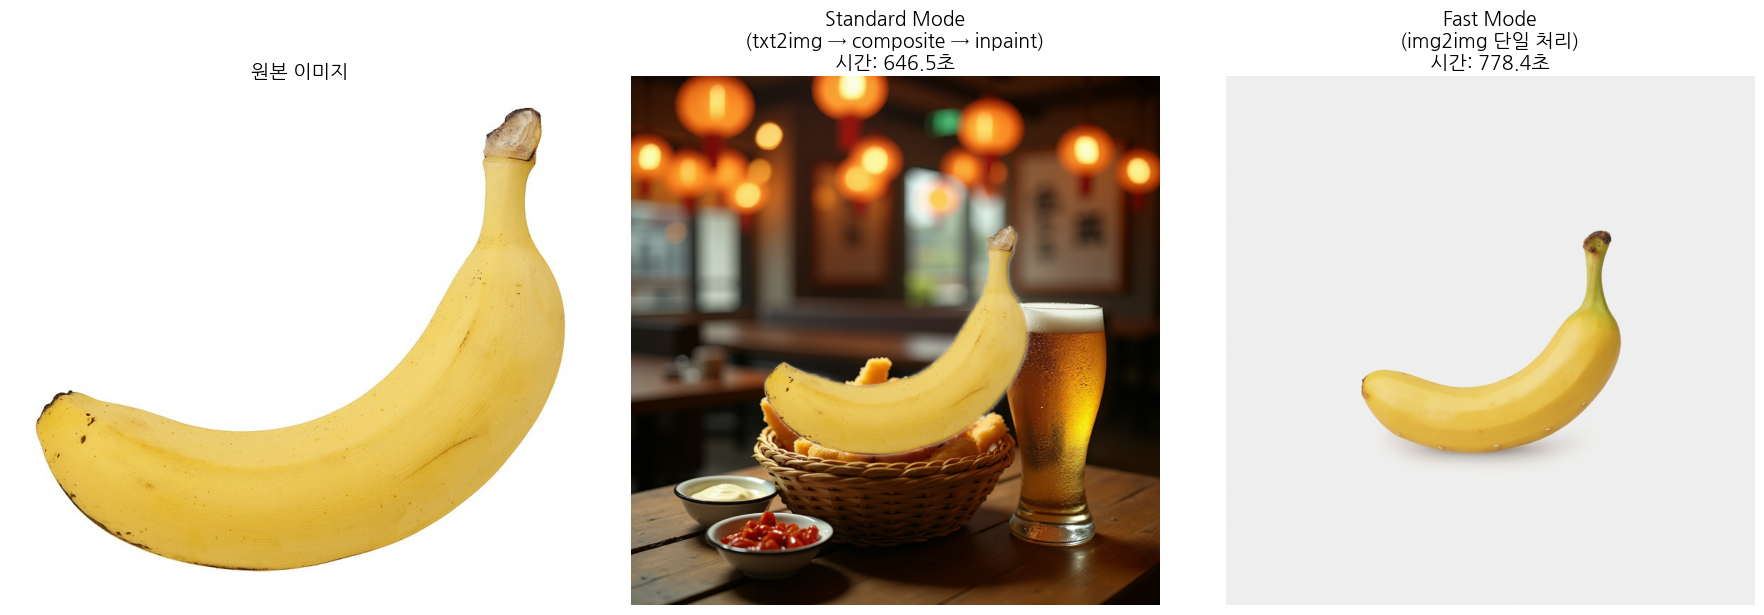


성능 비교 요약
Standard Mode: 646.51초
Fast Mode:     778.44초
속도 향상:     0.83x

품질 비교:
- Standard Mode: 상품 완벽 보존, 경계 자연스러움 (Inpainting)
- Fast Mode:     처리 속도 빠름, 상품 변형 가능성 있음


In [14]:
# ========================================
# 결과 비교 시각화
# ========================================
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 원본
axes[0].imshow(image_png)
axes[0].set_title("원본 이미지", fontsize=14, fontweight='bold')
axes[0].axis("off")

# Standard Mode
axes[1].imshow(result_standard)
axes[1].set_title(f"Standard Mode\n(txt2img → composite → inpaint)\n시간: {standard_time:.1f}초", 
                  fontsize=14, fontweight='bold')
axes[1].axis("off")

# Fast Mode
axes[2].imshow(result_fast)
axes[2].set_title(f"Fast Mode\n(img2img 단일 처리)\n시간: {fast_time:.1f}초", 
                  fontsize=14, fontweight='bold')
axes[2].axis("off")

plt.tight_layout()
plt.savefig("outputs/comparison_fast_vs_standard.png", dpi=150, bbox_inches='tight')
plt.show()

# 성능 비교 출력
print("\n" + "="*50)
print("성능 비교 요약")
print("="*50)
print(f"Standard Mode: {standard_time:.2f}초")
print(f"Fast Mode:     {fast_time:.2f}초")
print(f"속도 향상:     {standard_time/fast_time:.2f}x")
print("="*50)
print("\n품질 비교:")
print("- Standard Mode: 상품 완벽 보존, 경계 자연스러움 (Inpainting)")
print("- Fast Mode:     처리 속도 빠름, 상품 변형 가능성 있음")
print("="*50)